In [17]:
import nibabel
import os
from pathlib import Path
import numpy as np

In [1]:
def parse_labels(raw_csv_file, output_file):
    
    import csv
    csv_columns = ['run','trial','global time', 'run time', 'morph level', 'couple', 'response', 'response time']
    csv_file = output_file
    
    f = open(raw_csv_file)
    all_lines = f.readlines()
    
    to_be_added = []
    morph_level = None
    couple = None
    is_complete = False
    new_morph = False
    nb_item = 0
    nb_run = 0
    
    for line in all_lines:
        
        if line.find('Debut_run ')>-1:
            nb_run += 1
            global_t_start = None
            nb_item = 0

        if line.find('Synchro_IRM')>-1:
            global_t_start = int(line.split(',')[0])
                
        if line.find('morph_')>-1:
            new_morph = True
            nb_item += 1
            is_complete = False
            file_name = line.split(',')[3].split(' ')[1]
            file_name = file_name.split("\\")[2]
            morph_level = int(file_name.split('_')[1])
            couple = int(file_name.split('_')[2].split('.')[0])
            t_start = int(line.split(',')[3].split(' ')[2])
        
        if not is_complete and new_morph:
            if line.find('bouton_1')>-1:
                response = 1
                response_time = int(line.split(',')[3].split(' ')[1]) + 500
                is_complete = True
                new_morph = False
            elif line.find('bouton_2')>-1:
                response = 0
                response_time = None
                is_complete = True
                new_morph = False
                
        if is_complete:
            to_add = {'run' : nb_run, 
                      'trial' : nb_item,
                      'global time' : t_start, 
                      'run time' :  t_start - global_t_start,
                      'morph level' : morph_level,
                      'couple' : couple, 
                      'response' : response, 
                      'response time' : response_time}
            
            to_be_added += [to_add]
            is_complete = False

    try:
        with open(output_file, 'w') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
            writer.writeheader()
            for data in to_be_added:
                writer.writerow(data)
    except IOError:
        print("I/O error")

In [8]:
for file in os.listdir(Path("labels/raw")):
    parse_labels(Path("labels/raw") / file, Path("labels") / file)

In [18]:
def view_results(subject=1, run='all'):

    import pandas
    from pathlib import Path

    labels = pandas.read_csv(f'labels/labels_{subject}.csv')
    
    if run == 'all':
        x = labels['morph level']
        y = labels['response']
        z = labels['response time']
    else:
        pass
    
    import pylab as plt
    values = np.unique(x)
    results = {}
    results['response'] = {'mean' : np.zeros(len(values)), 'std' : np.zeros(len(values))}
    results['response_time'] = {'mean' : np.zeros(len(values)), 'std' : np.zeros(len(values))}
    for count, v in enumerate(values):
        mask = (x == v)
        results['response']['mean'][count] = np.mean(y[mask])
        results['response']['std'][count] = np.std(y[mask])/np.sqrt(np.sum(mask))

        results['response_time']['mean'][count] = np.mean(z[mask])
        results['response_time']['std'][count] = np.std(z[mask])/np.sqrt(np.sum(mask))

    fig, ax = plt.subplots(ncols=2, squeeze=False, figsize=(15,5))
    ax[0,0].plot(values, results['response']['mean'])
    ax[0,0].fill_between(values, results['response']['mean'] - results['response']['std'], 
                     results['response']['mean'] + results['response']['std'], alpha=0.25)
    ax[0,0].set_xlabel('% morph')
    ax[0,0].set_ylabel('response')

    ax[0,1].plot(values, results['response_time']['mean'])
    ax[0,1].fill_between(values, results['response_time']['mean'] - results['response_time']['std'], 
                     results['response_time']['mean'] + results['response_time']['std'], alpha=0.25)
    ax[0,1].set_xlabel('% morph')
    ax[0,1].set_ylabel('response time (ms)')

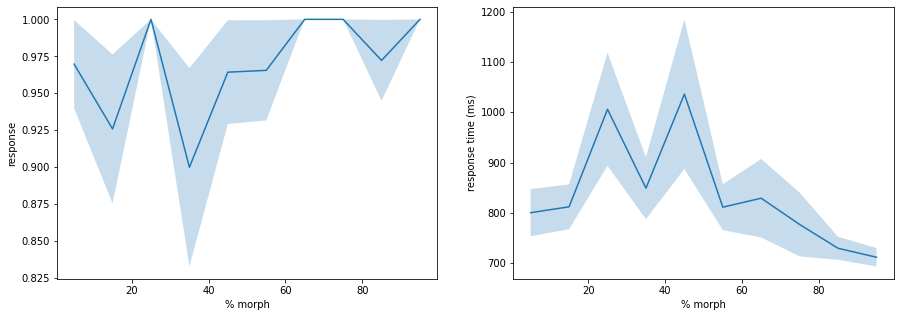

In [21]:
view_results(1)